### Sound Localization Using Delay-and-Sum (DAS) Algorithm
`- Siva Sundar, EE23B151`

This code implements the Delay-and-Sum (DAS) algorithm for locating obstacles by analyzing reflected wave data. In this setup, a source located at the origin emits waves across the XY-plane. If an obstacle is present, it reflects these waves perfectly, with no energy loss, back to a linear array of microphones placed along the y-axis. Each microphone captures a shifted version of the source wave due to the varying distances the reflected waves travel.

The goal is to use the DAS algorithm to determine the location of the obstacle. By aligning and summing the time-shifted waveforms from each microphone, the location with the maximum summed amplitude pinpoints the obstacle’s position.

In [1]:
import numpy as np                      # For Numpy arrays
import matplotlib.pyplot as plt         # For plotting curves and heatmap

Defining a function for generating **sinc(t)** sound pulses.

In [2]:
# Sinc wave
SincP = 5.0             # Time dilation factor for sinc pulse (narrowness)
Nsamp = 100             # Number of samples in time
time_per_samp = 0.1     # Time difference between two samples

# Nsamp time instants with spacing of dist_per_samp
t = np.linspace(time_per_samp, time_per_samp * Nsamp, Nsamp)

# Source sound wave - time axis and wave
def wsrc(t):
    return np.sinc(SincP*t)

Generating different sinc waves (without dilation factor)

Text(0.5, 1.0, 'Shifted sinc')

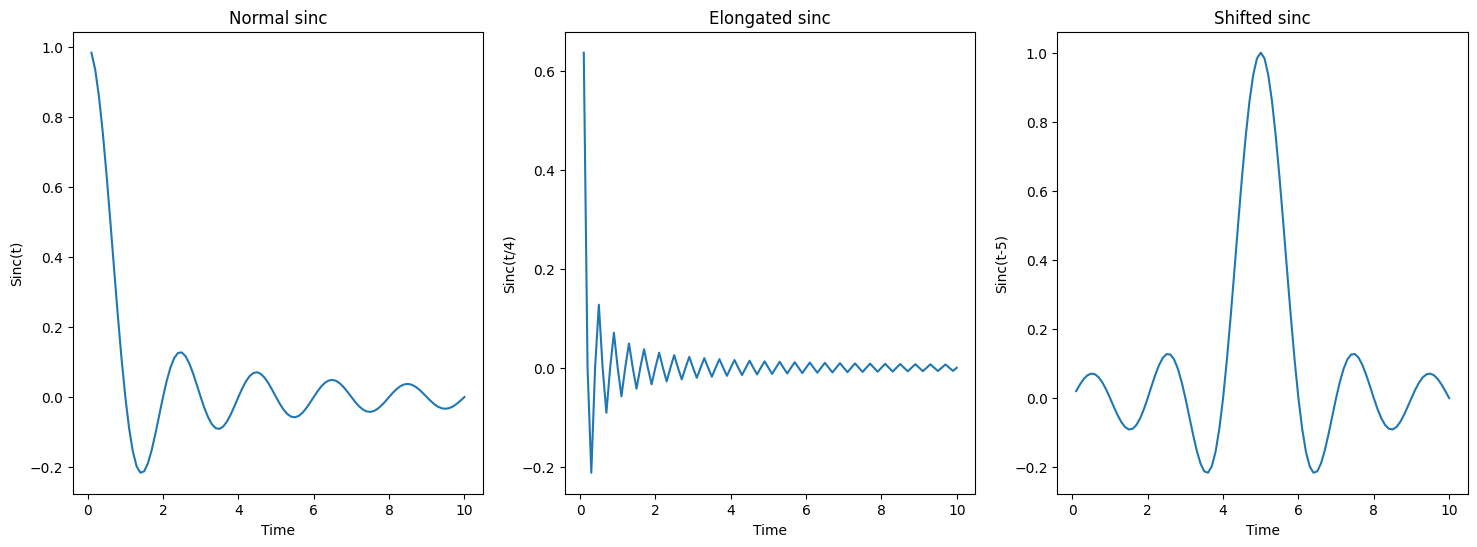

In [3]:
y1 = wsrc(t/SincP)          # Normal sinc (without dilation factor)
y2 = wsrc(5*t/SincP)        # Compressed sinc
y3 = wsrc((t-5)/SincP)      # Shifted sinc

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18,6))
ax1.plot(t,y1); ax1.set_xlabel('Time'); ax1.set_ylabel('Sinc(t)'); ax1.set_title("Normal sinc")
ax2.plot(t,y2); ax2.set_xlabel('Time'); ax2.set_ylabel('Sinc(t/4)'); ax2.set_title("Elongated sinc");
ax3.plot(t,y3); ax3.set_xlabel('Time'); ax3.set_ylabel('Sinc(t-5)'); ax3.set_title("Shifted sinc")

**Q1)** The plots below show two example sinc pulses. How will you generate pulses that look
like this? Which parameter should be changed? What effect do you think this will have on the final
image?

Answer:
> 
>The param to change the shape (compress or elongate) of sinc wave is the **dilation factor** SincP:
>* Setting SincP = 1 gives first graph.
>* Setting SincP = 5 produces second graph.  (To make it smooth use smaller **time_per_samp** value)
>
>The effect this has on the final DAS heatmap is that, if sinc wave is broader, we will get a broader peak and if sinc wave is compressed, we will get a sharp peak. (The effect is explained in **Q5**.)

Now, I will try to find obstacle location with DAS for the **system settings** which Prof mentioned in the document:
- Source at origin, Microphone array of 64 mics along y axis with pitch between them as 0.1 units
- 200 time samples and distance between two time samples is 0.1
- Speed of sound = 2.0 units
- Given, obstacle is at (3, -1)

In [4]:
Nmics = 64              # No. of mics
Nsamp = 200             # No. of samples in time
dist_per_samp = 0.1     # Proxy for sampling rate
src = (0, 0)            # Source coords
pitch = 0.1             # Spacing between mics
C = 2.0                 # Speed of sound in the medium
mics = np.linspace(-(Nmics-1)*pitch/2, +(Nmics-1)*pitch/2, Nmics)   # Locations of mics (lies on y-axis)
d = np.linspace(dist_per_samp, dist_per_samp * Nsamp, Nsamp)        # Distance Time instants
t = np.linspace(1, Nsamp, Nsamp)                                    # Samp no.
obstacle = (3, -1)      # Location of point obstacle

Helper function to calculate *total distance* for sound wave to travel from **source** to **obstacle** and then reflect back to **mic**.

In [5]:
# Total Distance for wave : src -> point -> mic
def dist(src, pt, mic):
    d1 = ((pt[0]-src[0])**2 + (pt[1]-src[1])**2)**0.5   # src -> point
    d2 = ((pt[0])**2 + (pt[1]-mic)**2)**0.5             # point -> mic
    return d1 + d2

Creating the sound wave plot given in document for obstacle at (3, -1) and plotting it.

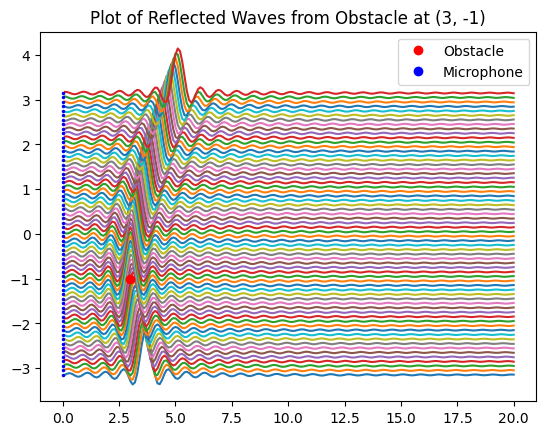

In [6]:
data = np.zeros((Nmics, Nsamp))                 # Stores the sound wave plot
time_per_samp = dist_per_samp/C
for i in range(len(mics)):
    path_diff = ((obstacle[0])**2 + (obstacle[1]-mics[i])**2)**0.5             # Obstacle -> Mic
    sig_at_mic = wsrc((t-path_diff/dist_per_samp)*time_per_samp)       # Signal recieved at mic will be shifted by path_diff
    plt.plot(d,(sig_at_mic + mics[i]))          # Delayed signal Vs sample, inline with y coord of mic
    plt.plot(0,mics[i],'bo',markersize=1.5)     # Blue points for mics
    data[i, :] = sig_at_mic

plt.title(f"Plot of Reflected Waves from Obstacle at {obstacle}")
plt.plot(obstacle[0],obstacle[1],'ro', label='Obstacle')
plt.plot([],[], 'bo',label='Microphone')
plt.legend()
plt.show()

This is the graph which takes into account the total path difference, ie, for each mic, the shift in its corresponding sinc wave represents the distance which the wave has to travel from source to obstacle and then from obstacle to mic.

Heatmap representing the intensity of sound wave.

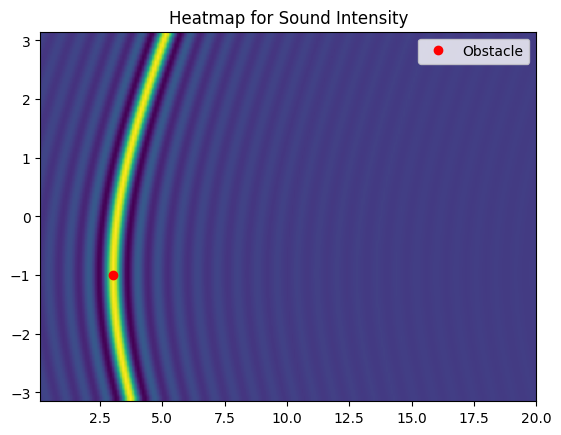

In [7]:
plt.imshow(data, aspect='auto', extent=[d[0],d[-1],mics[-1],mics[0]])       # Here, Y is inverted while plotting
plt.gca().invert_yaxis()
plt.title(f"Heatmap for Sound Intensity")
plt.plot(obstacle[0],obstacle[1],'ro', label='Obstacle')
plt.legend()
plt.show()

Because Sample No.s and Sample distance have a one to one correspondence, we can change the X-axis from distance to corresponding samples directly (without any alterations to the shape of the curve, as it is goverened by time).

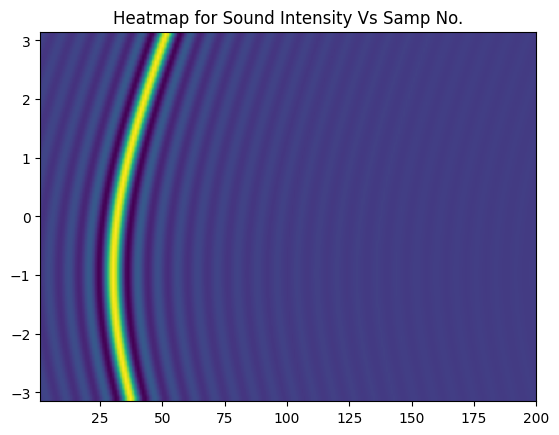

In [8]:
plt.imshow(data, aspect='auto', extent=[t[0],t[-1],mics[-1],mics[0]])       # Just changed array from d to t
plt.gca().invert_yaxis()
plt.title(f"Heatmap for Sound Intensity Vs Samp No.")
plt.show()

Defining function which implements DAS algorithm:
- Inputs:
    - Sound wave data
    - Distance between two consecutive samples
    - Speed of Sound
    - Source coordinates
    - Function which is used to find path difference
    - X axis bound for iteration    (How to choose such a bound is explained in **Q2**)
- Outputs:
    - Delay-Sum matrix
    - Arrays which contain mic location and sample locations (can be used later for plotting DS matrix)

Point index : (30, 22)
Predicted location : (3.0, -1.0)


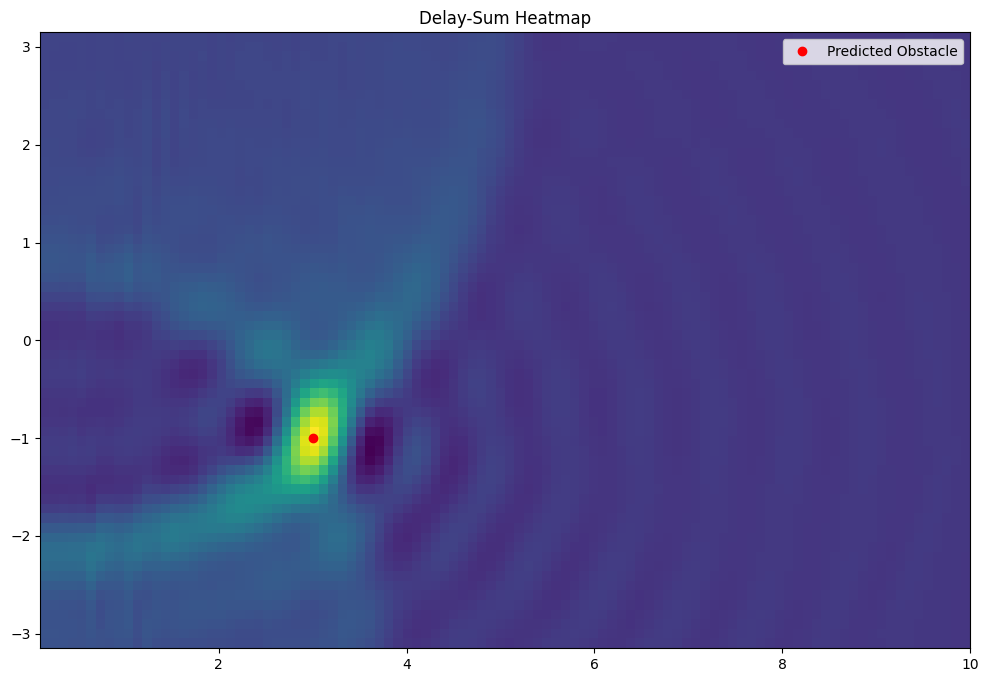

In [9]:
# Delay-Sum Algorithm
def DAS(data, dist_per_samp, C, src, dist, x_max=0):
    Nmics, Nsamp = data.shape
    if x_max != 0:
        Nsamp = x_max
    time_per_samp = dist_per_samp/C
    delay_sum = np.zeros((Nmics, Nsamp))
    mics = np.linspace(-(Nmics-1)*pitch/2, +(Nmics-1)*pitch/2, Nmics)
    d = np.linspace(dist_per_samp, dist_per_samp * Nsamp, Nsamp)
    t = np.linspace(1, Nsamp, Nsamp)
    for x in range(Nsamp):
        for y in range(Nmics):
            obstacle_pred = (d[x], mics[y])
            sum = 0                 # Stores the sound wave plot for predicted obstacle
            for i in range(len(mics)):
                path_diff = dist(src,obstacle_pred,mics[i])
                samp_dist = (path_diff/dist_per_samp)
                sig_at_mic = wsrc((t-samp_dist)*time_per_samp)            # Signal recieved at mic will be shifted by samp_dist
                # Find the index of the max value in `sig_at_mic`
                max_idx = np.argmax(sig_at_mic)
                sum += data[i, max_idx]
            delay_sum[y,x] = sum

    return delay_sum, mics, d
dist_per_samp=0.1
delay_sum, mics, d = DAS(
    data,
    dist_per_samp,
    C,
    src,
    lambda src, pt, mic: ((pt[0])**2 + (pt[1]-mic)**2)**0.5,      # Function to calculate path difference between obstacle and mic
    Nsamp//2
)

# Find the index of the peak intensity
max_index = np.unravel_index(np.argmax(delay_sum), delay_sum.shape)
max_index = (max_index[1]+1,max_index[0]+1)     # Actual location is given by index + 1 and (y,x)->(x,y)
pred_loc = (max_index[0]*dist_per_samp, mics[max_index[1]]-pitch*0.5)

print(f"""Point index : {max_index}
Predicted location : ({pred_loc[0]}, {pred_loc[1]:.1f})""")
plt.figure(figsize=(12,8))
plt.imshow(delay_sum,aspect='auto',extent=[d[0],d[-1],mics[-1],mics[0]])       # Y is inverted while plotting
plt.plot(pred_loc[0], pred_loc[1],'ro', label='Predicted Obstacle')
plt.gca().invert_yaxis()
plt.title(f"Delay-Sum Heatmap")
plt.legend()
plt.show()

In the above output we can see that we only need to iterate upto where the peaks lie for each mic. Other parts of the data are not needed. That's why I added another param `samp` while defining `DAS()` which is used as a limit to iteration over x values.

In the case of multiple obstacles (will be seen in rx2.txt and rx3.txt files), we need to define a function which finds 'n' maximas which are all seperated by a distance epsilon to each other.

In [10]:
def maxima_finder(arr, n_max=1, epsilon=0):
    temp = np.copy(arr)  # Create a deep copy
    indices = []
    values = []

    while n_max != 0:
        # Find the current maximum and its indices
        max_val = temp.max()
        cur_indices = np.array(np.unravel_index(np.argmax(temp), temp.shape))

        # Check if the current maximum is far enough from previous maxima
        if all(np.linalg.norm(cur_indices - np.array(ind)) > epsilon for ind in indices):
            # Append the current maximum's index and value
            indices.append(tuple(cur_indices))
            values.append(max_val)
            n_max -= 1              # Found one max
        # Set the current maximum to a low value (effectively removing it)
        temp[tuple(cur_indices)] = 0
    return indices, values

In [11]:
# Load data from files
rx2 = np.loadtxt('rx2.txt')
rx3 = np.loadtxt('rx3.txt')

# Source: x,y coordinates: x: 0+, y: [-Y, +Y] where Y determined by pitch and Nmics
src = (0, 0)
pitch = 0.1             # Spacing between microphones
dist_per_samp = 0.1     # proxy for sampling rate
C = 2                   # Speed of sound in the medium
SincP = 5.0             # Time dilation factor for sinc pulse: how narrow

 Point index   |     Predicted location   
---------------|-------------------------
   (30, 22)    |	( 3.0 ,-1.0 )
   (21, 32)    |	( 2.1 ,-0.0 )


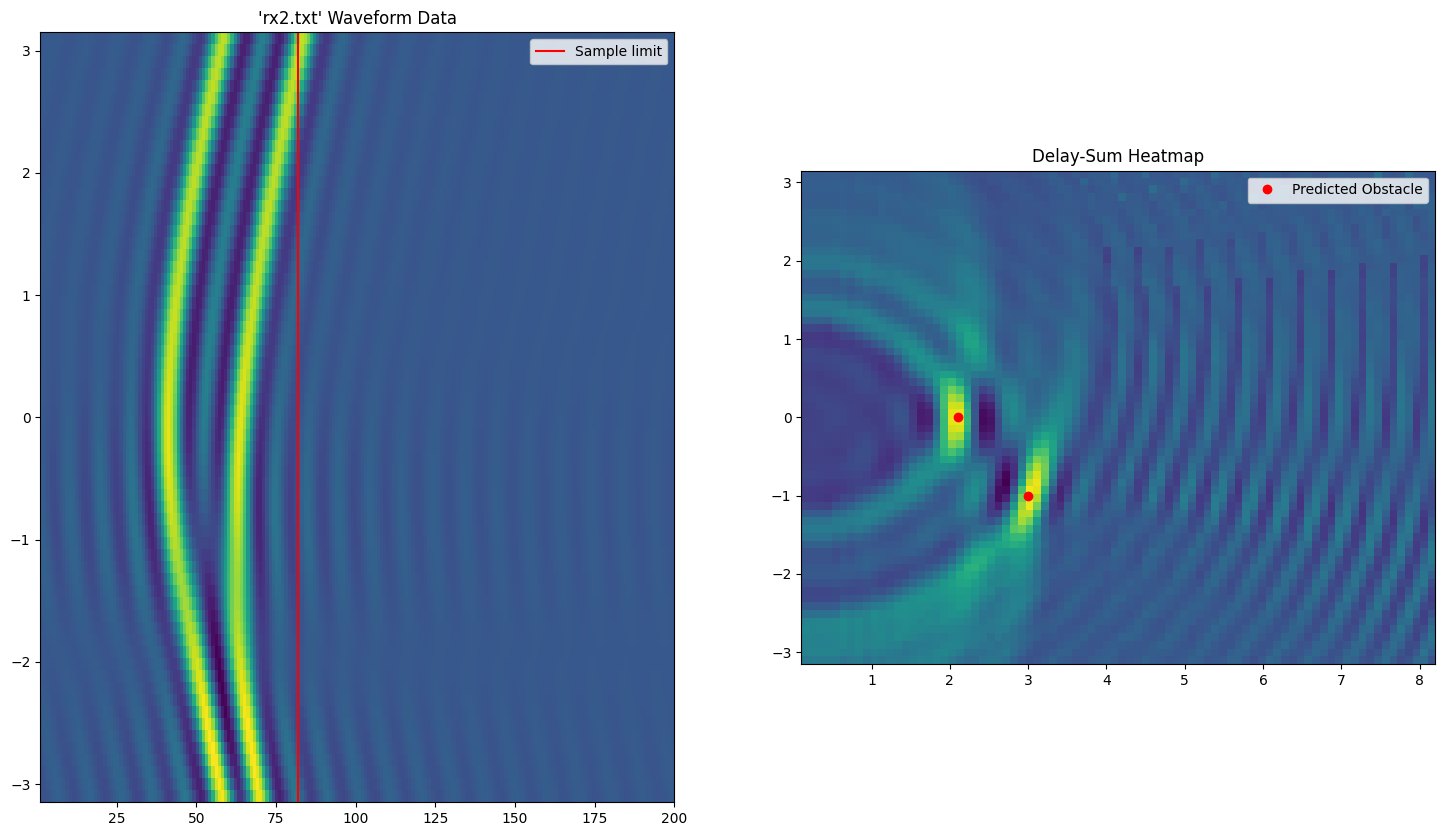

In [12]:
fig, (ax1, ax2) = plt.subplots(
    1, 2,
    figsize=(18, 10),
    gridspec_kw={'width_ratios': [1, 1]}  # Set ax1 to be twice as tall as ax2
)
ax1.set_title("'rx2.txt' Waveform Data")
ax2.set_title("Delay-Sum Heatmap")

# Using sound data in rx2.txt
data = rx2
Nmics = data.shape[0]
Nsamp = data.shape[1]

# Calculating the sample limit
t = np.linspace(1, Nsamp, Nsamp)
points, _ = maxima_finder(data, 100, 1)
x_max = max([point[1] for point in points])

# Using DAS algorithm to find obstacle locations for rx2.txt
delay_sum, mics, d = DAS(data, dist_per_samp, C, src, dist, x_max)
indices, _ = maxima_finder(delay_sum, n_max=2, epsilon=2)
pred_locs = []
point_ind = []
for index in indices:
    # Convert index to (x, y) in 1-based indexing
    max_index = (index[1] + 1, index[0] + 1)
    point_ind.append(max_index)
    pred_loc = (max_index[0] * dist_per_samp, mics[max_index[1]] - pitch * 0.5)
    pred_locs.append(pred_loc)

# Print in a formatted table
print(" Point index   |     Predicted location   ")
print("---------------|-------------------------")
for idx, loc in zip(point_ind, pred_locs):
    print(f"{str(idx):^15}|\t({loc[0]:^5.1f},{loc[1]:^5.1f})")
    ax2.plot(loc[0], loc[1],'ro')

# Plotting the sound waveform data
line = [[x_max for _ in range(len(mics))], [mic for mic in mics]]
ax1.plot(line[0], line[1], 'r',label='Sample limit')
ax1.imshow(data,aspect='auto', extent=[t[0],t[-1],mics[-1],mics[0]])
ax2.plot([],[],'ro',label='Predicted Obstacle')
ax1.legend()
# Plotting the DAS Heatmap
ax2.imshow(delay_sum,extent=[d[0],d[-1],mics[-1],mics[0]])       # Y is inverted while plotting
ax2.invert_yaxis()
ax2.legend()
ax1.invert_yaxis()
# Show the final plot
plt.show()

 Point index   |     Predicted location   
---------------|-------------------------
   (30, 22)    |	( 3.0 ,-1.0 )
   (40, 39)    |	( 4.0 , 0.7 )
   (20, 32)    |	( 2.0 ,-0.0 )


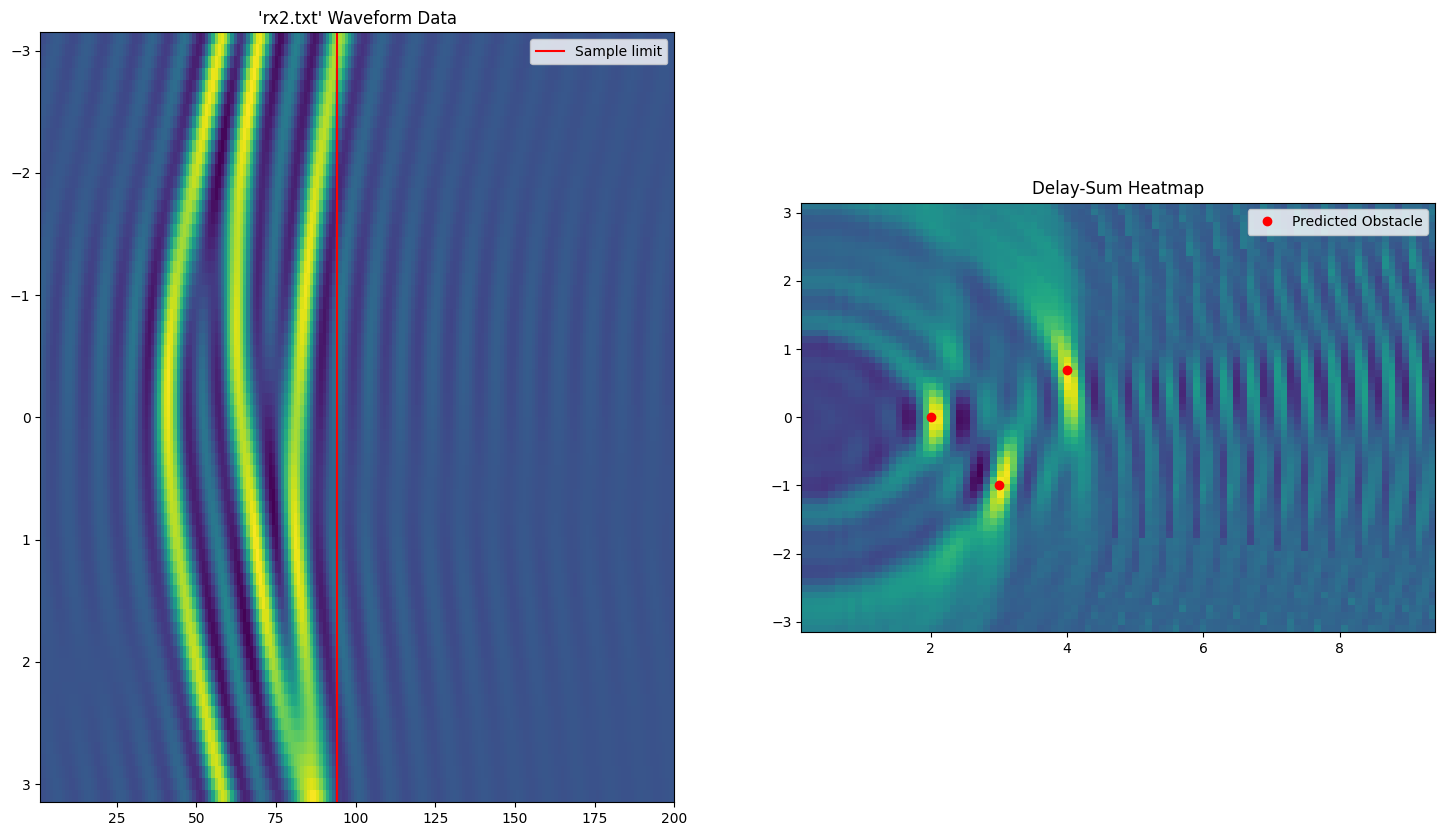

In [13]:
fig, (ax1, ax2) = plt.subplots(
    1, 2,
    figsize=(18, 10),
    gridspec_kw={'width_ratios': [1, 1]}  # Set ax1 to be twice as tall as ax2
)
ax1.set_title("'rx2.txt' Waveform Data")
ax2.set_title("Delay-Sum Heatmap")

# Using sound data in rx2.txt
data = rx3
Nmics = data.shape[0]
Nsamp = data.shape[1]

# Calculating the sample limit
t = np.linspace(1, Nsamp, Nsamp)
points, _ = maxima_finder(data, 200, 1)         # Increased to 200 to get more accurate x_max
x_max = max([point[1] for point in points])

# Using DAS algorithm to find obstacle locations for rx3.txt
delay_sum, mics, d = DAS(data, dist_per_samp, C, src, dist, x_max)
indices, _ = maxima_finder(delay_sum, n_max=3, epsilon=2)
pred_locs = []
point_ind = []
for index in indices:
    # Convert index to (x, y) in 1-based indexing
    max_index = (index[1] + 1, index[0] + 1)
    point_ind.append(max_index)
    pred_loc = (max_index[0] * dist_per_samp, mics[max_index[1]] - pitch * 0.5)
    pred_locs.append(pred_loc)

# Print in a formatted table
print(" Point index   |     Predicted location   ")
print("---------------|-------------------------")
for idx, loc in zip(point_ind, pred_locs):
    print(f"{str(idx):^15}|\t({loc[0]:^5.1f},{loc[1]:^5.1f})")
    ax2.plot(loc[0], loc[1],'ro')

# Plotting the sound waveform data
line = [[x_max for _ in range(len(mics))], [mic for mic in mics]]
ax1.plot(line[0], line[1], 'r',label='Sample limit')
ax1.imshow(data,aspect='auto', extent=[t[0],t[-1],mics[-1],mics[0]])
ax2.plot([],[],'ro',label='Predicted Obstacle')
ax1.legend()
# Plotting the DAS Heatmap
ax2.imshow(delay_sum,extent=[d[0],d[-1],mics[-1],mics[0]])       # Y is inverted while plotting
ax2.invert_yaxis()
ax2.legend()

# Show the final plot
plt.show()

This section is for **Q5**

Modifying DAS function so that it takes in different number of samples and mics:

In [14]:
# Delay-Sum Algorithm
def DAS(data, Nsamp, Nmics, dist_per_samp, C, src, dist):
    time_per_samp = dist_per_samp/C
    delay_sum = np.zeros((Nmics, Nsamp))
    mics = np.linspace(-(Nmics-1)*pitch/2, +(Nmics-1)*pitch/2, Nmics)
    d = np.linspace(dist_per_samp, dist_per_samp * Nsamp, Nsamp)
    t = np.linspace(1, Nsamp, Nsamp)
    for x in range(Nsamp):
        for y in range(Nmics):
            obstacle_pred = (d[x], mics[y])
            sum = 0                 # Stores the sound wave plot for predicted obstacle
            for i in range(len(mics)):
                path_diff = dist(src,obstacle_pred,mics[i])
                samp_dist = (path_diff/dist_per_samp)
                sig_at_mic = wsrc((t-samp_dist)*time_per_samp)            # Signal recieved at mic will be shifted by samp_dist
                # Find the index of the max value in `sig_at_mic`
                max_idx = np.argmax(sig_at_mic)
                sum += data[i, max_idx]
            delay_sum[y,x] = sum

    return delay_sum, mics, d

Defining the system and test cases.

In [15]:
Nmics_list = [8,32,64]      # No. of mics
Nsamp_list = [50,100,200]   # No. of samples in time
dist_per_samp = 0.1         # Proxy for sampling rate
src = (0, 0)                # Source coords
pitch = 0.1                 # Spacing between mics
C = 1.0                     # Speed of sound in the medium
obstacle = (3, -1)          # Location of point obstacle

Fixing Nmics = 8, and plotting for each Nsamp value in Nsamp_list.

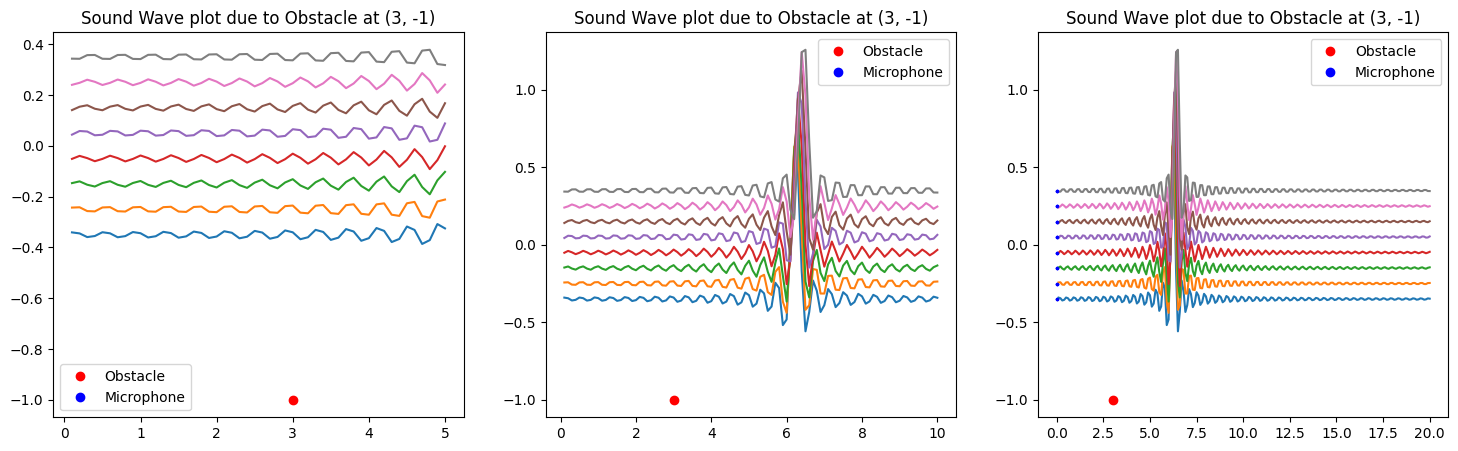

In [16]:
Nmics = Nmics_list[0]
mics = np.linspace(-(Nmics-1)*pitch/2, +(Nmics-1)*pitch/2, Nmics)   # Locations of mics (lies on y-axis)

data1 = np.zeros((Nmics, Nsamp_list[0]))                 # Stores the sound wave plot
data2 = np.zeros((Nmics, Nsamp_list[1]))
data3 = np.zeros((Nmics, Nsamp_list[2]))
data_list = [data1, data2, data3]

fig, axes = plt.subplots(
    1, 3,
    figsize=(18, 5),
    gridspec_kw={'width_ratios': [1, 1, 1]}  # Set ax1 to be twice as tall as ax2
)

for data_ind in range(len(data_list)):
    Nsamp = Nsamp_list[data_ind]
    t = np.linspace(1, Nsamp, Nsamp)                                    # Samp no.
    d = np.linspace(dist_per_samp, dist_per_samp * Nsamp, Nsamp)        # Distance Time instants
    time_per_samp = dist_per_samp/C
    for i in range(len(mics)):
        path_diff = dist(src,obstacle,mics[i])             # Obstacle -> Mic
        sig_at_mic = wsrc((t-path_diff/dist_per_samp)*time_per_samp)       # Signal recieved at mic will be shifted by path_diff
        axes[data_ind].plot(d,(sig_at_mic + mics[i]))          # Delayed signal Vs sample, inline with y coord of mic
        plt.plot(0,mics[i],'bo',markersize=1.5)     # Blue points for mics
        data_list[data_ind][i, :] = sig_at_mic
    axes[data_ind].set_title(f"Sound Wave plot due to Obstacle at {obstacle}")
    axes[data_ind].plot(obstacle[0],obstacle[1],'ro', label='Obstacle')
    axes[data_ind].plot([],[], 'bo',label='Microphone')
    axes[data_ind].legend()

Nmics = 8
Nsamp	Point index	Predicted location
50	(23, 1)		(2.3, -0.3)
100	(32, 2)		(3.2, -0.2)
200	(32, 2)		(3.2, -0.2)


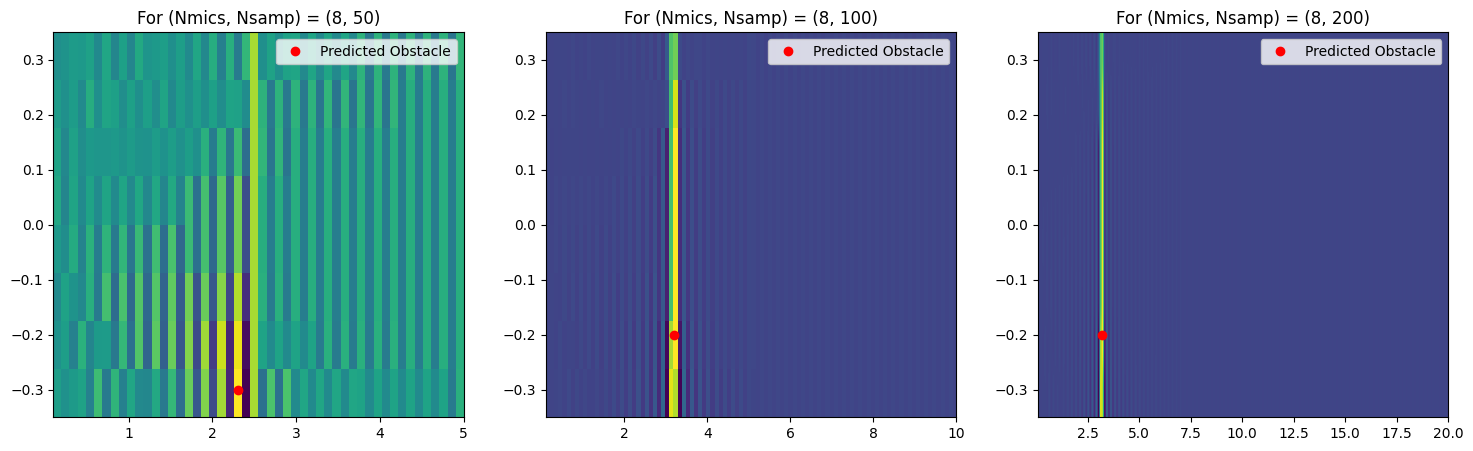

In [17]:
fig, axes = plt.subplots(
    1, 3,
    figsize=(18, 5),
    gridspec_kw={'width_ratios': [1, 1, 1]}  # Set ax1 to be twice as tall as ax2
)
print("Nmics =", Nmics)
print("Nsamp\tPoint index\tPredicted location")
for data_ind in range(len(data_list)):
    Nsamp = Nsamp_list[data_ind]
    delay_sum, mics, d = DAS(data_list[data_ind], Nsamp, Nmics, dist_per_samp, C, src, dist)
    # Find the index of the peak intensity
    max_index = np.unravel_index(np.argmax(delay_sum), delay_sum.shape)
    max_index = (max_index[1]+1,max_index[0]+1)     # Actual location is given by index + 1 and (y,x)->(x,y)
    pred_loc = (max_index[0]*dist_per_samp, mics[max_index[1]]-pitch*0.5)
    print(f"{Nsamp}\t{max_index}\t\t({pred_loc[0]:.1f}, {pred_loc[1]:.1f})")
    axes[data_ind].set_title(f"For (Nmics, Nsamp) = {(Nmics, Nsamp)}")
    axes[data_ind].plot(pred_loc[0], pred_loc[1],'ro')
    axes[data_ind].imshow(delay_sum,aspect='auto',extent=[d[0],d[-1],mics[-1],mics[0]])
    axes[data_ind].invert_yaxis()
    axes[data_ind].plot([],[],'ro',label='Predicted Obstacle')
    axes[data_ind].legend()

Fixing Nmics = 32, and plotting for each Nsamp value in Nsamp_list.

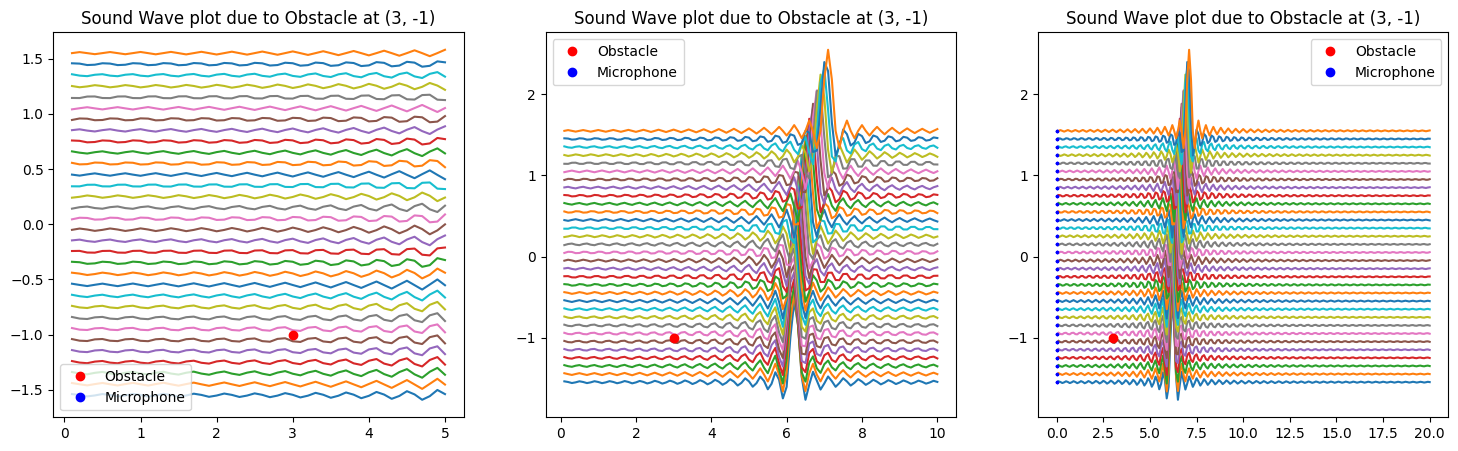

In [18]:
Nmics = Nmics_list[1]
mics = np.linspace(-(Nmics-1)*pitch/2, +(Nmics-1)*pitch/2, Nmics)   # Locations of mics (lies on y-axis)

data1 = np.zeros((Nmics, Nsamp_list[0]))                 # Stores the sound wave plot
data2 = np.zeros((Nmics, Nsamp_list[1]))
data3 = np.zeros((Nmics, Nsamp_list[2]))
data_list = [data1, data2, data3]

fig, axes = plt.subplots(
    1, 3,
    figsize=(18, 5),
    gridspec_kw={'width_ratios': [1, 1, 1]}  # Set ax1 to be twice as tall as ax2
)

for data_ind in range(len(data_list)):
    Nsamp = Nsamp_list[data_ind]
    t = np.linspace(1, Nsamp, Nsamp)                                    # Samp no.
    d = np.linspace(dist_per_samp, dist_per_samp * Nsamp, Nsamp)        # Distance Time instants
    time_per_samp = dist_per_samp/C
    for i in range(len(mics)):
        path_diff = dist(src,obstacle,mics[i])             # Obstacle -> Mic
        sig_at_mic = wsrc((t-path_diff/dist_per_samp)*time_per_samp)       # Signal recieved at mic will be shifted by path_diff
        axes[data_ind].plot(d,(sig_at_mic + mics[i]))          # Delayed signal Vs sample, inline with y coord of mic
        plt.plot(0,mics[i],'bo',markersize=1.5)     # Blue points for mics
        data_list[data_ind][i, :] = sig_at_mic
    axes[data_ind].set_title(f"Sound Wave plot due to Obstacle at {obstacle}")
    axes[data_ind].plot(obstacle[0],obstacle[1],'ro', label='Obstacle')
    axes[data_ind].plot([],[], 'bo',label='Microphone')
    axes[data_ind].legend()

Nmics = 32
Nsamp	Point index	Predicted location
50	(32, 6)		(3.2, -1.0)
100	(30, 6)		(3.0, -1.0)
200	(30, 6)		(3.0, -1.0)


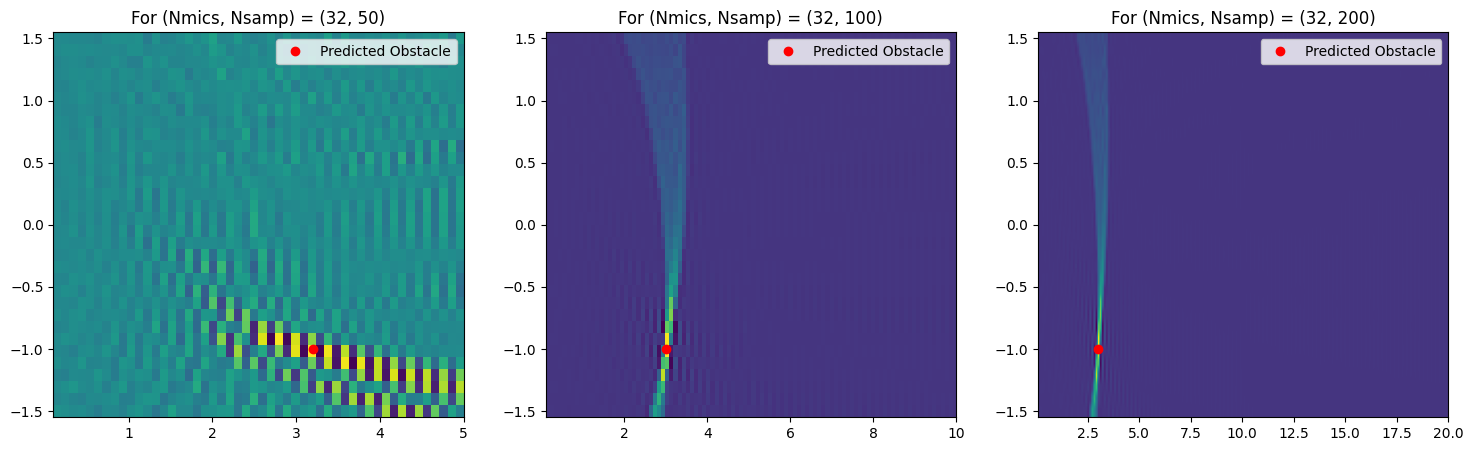

In [19]:
fig, axes = plt.subplots(
    1, 3,
    figsize=(18, 5),
    gridspec_kw={'width_ratios': [1, 1, 1]}  # Set ax1 to be twice as tall as ax2
)
print("Nmics =", Nmics)
print("Nsamp\tPoint index\tPredicted location")
for data_ind in range(len(data_list)):
    Nsamp = Nsamp_list[data_ind]
    delay_sum, mics, d = DAS(data_list[data_ind], Nsamp, Nmics, dist_per_samp, C, src, dist)
    # Find the index of the peak intensity
    max_index = np.unravel_index(np.argmax(delay_sum), delay_sum.shape)
    max_index = (max_index[1]+1,max_index[0]+1)     # Actual location is given by index + 1 and (y,x)->(x,y)
    pred_loc = (max_index[0]*dist_per_samp, mics[max_index[1]]-pitch*0.5)
    print(f"{Nsamp}\t{max_index}\t\t({pred_loc[0]:.1f}, {pred_loc[1]:.1f})")
    axes[data_ind].set_title(f"For (Nmics, Nsamp) = {(Nmics, Nsamp)}")
    axes[data_ind].plot(pred_loc[0], pred_loc[1],'ro')
    axes[data_ind].imshow(delay_sum,aspect='auto',extent=[d[0],d[-1],mics[-1],mics[0]])
    axes[data_ind].invert_yaxis()
    axes[data_ind].plot([],[],'ro',label='Predicted Obstacle')
    axes[data_ind].legend()

Fixing Nmics = 64, and plotting for each Nsamp value in Nsamp_list.

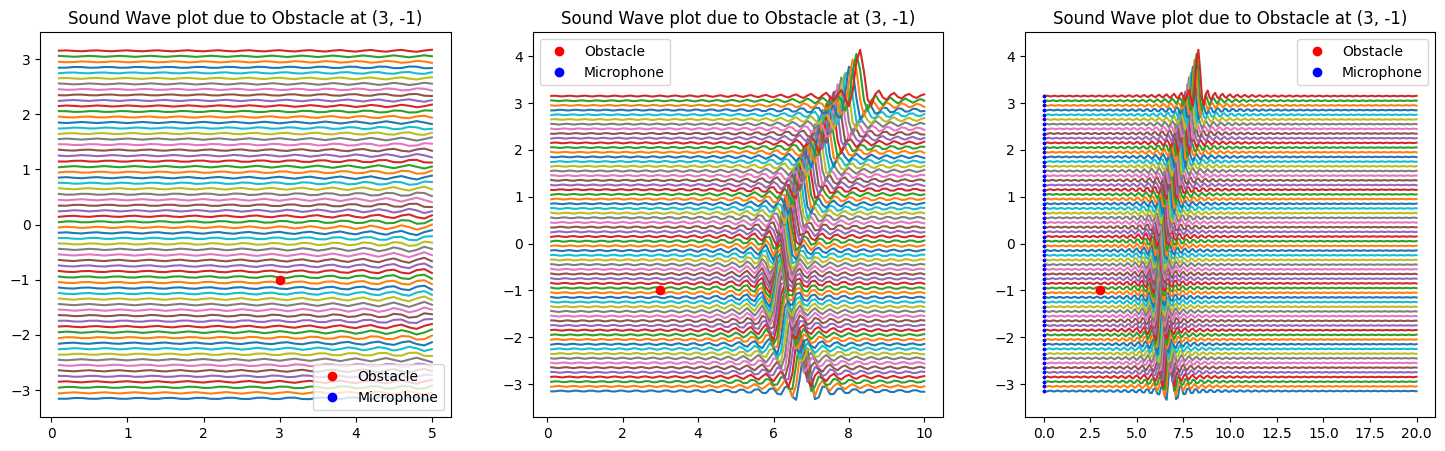

In [20]:
Nmics = Nmics_list[2]
mics = np.linspace(-(Nmics-1)*pitch/2, +(Nmics-1)*pitch/2, Nmics)   # Locations of mics (lies on y-axis)

data1 = np.zeros((Nmics, Nsamp_list[0]))                 # Stores the sound wave plot
data2 = np.zeros((Nmics, Nsamp_list[1]))
data3 = np.zeros((Nmics, Nsamp_list[2]))
data_list = [data1, data2, data3]

fig, axes = plt.subplots(
    1, 3,
    figsize=(18, 5),
    gridspec_kw={'width_ratios': [1, 1, 1]}  # Set ax1 to be twice as tall as ax2
)

for data_ind in range(len(data_list)):
    Nsamp = Nsamp_list[data_ind]
    t = np.linspace(1, Nsamp, Nsamp)                                    # Samp no.
    d = np.linspace(dist_per_samp, dist_per_samp * Nsamp, Nsamp)        # Distance Time instants
    time_per_samp = dist_per_samp/C
    for i in range(len(mics)):
        path_diff = dist(src,obstacle,mics[i])             # Obstacle -> Mic
        sig_at_mic = wsrc((t-path_diff/dist_per_samp)*time_per_samp)       # Signal recieved at mic will be shifted by path_diff
        axes[data_ind].plot(d,(sig_at_mic + mics[i]))          # Delayed signal Vs sample, inline with y coord of mic
        plt.plot(0,mics[i],'bo',markersize=1.5)     # Blue points for mics
        data_list[data_ind][i, :] = sig_at_mic
    axes[data_ind].set_title(f"Sound Wave plot due to Obstacle at {obstacle}")
    axes[data_ind].plot(obstacle[0],obstacle[1],'ro', label='Obstacle')
    axes[data_ind].plot([],[], 'bo',label='Microphone')
    axes[data_ind].legend()

Nmics = 64
Nsamp	Point index	Predicted location
50	(28, 23)		(2.8, -0.9)
100	(30, 22)		(3.0, -1.0)
200	(30, 22)		(3.0, -1.0)


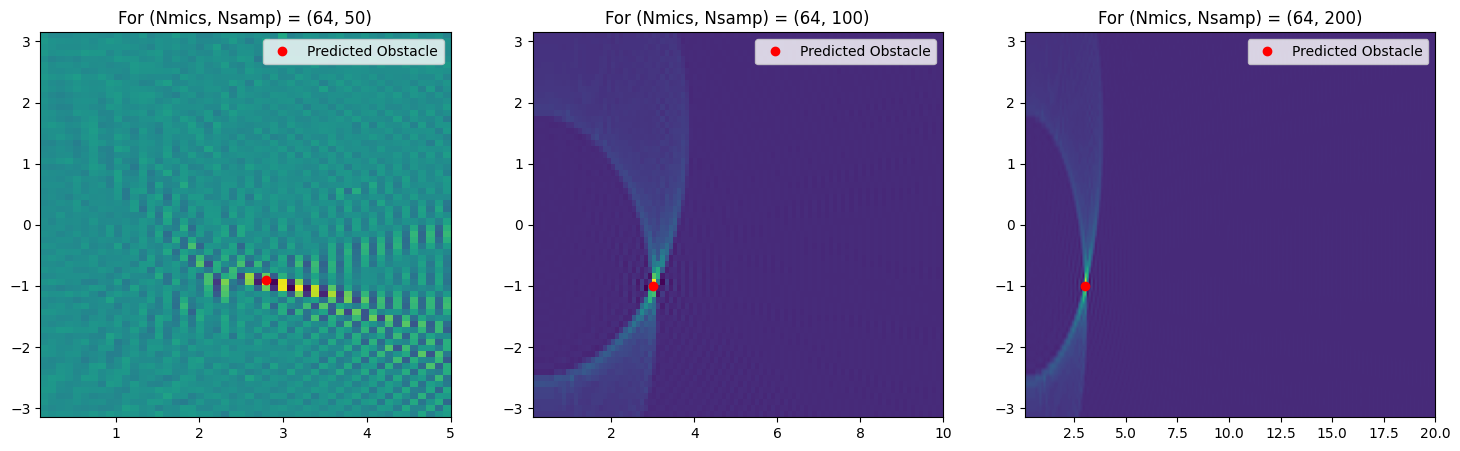

In [21]:
fig, axes = plt.subplots(
    1, 3,
    figsize=(18, 5),
    gridspec_kw={'width_ratios': [1, 1, 1]}  # Set ax1 to be twice as tall as ax2
)
print("Nmics =", Nmics)
print("Nsamp\tPoint index\tPredicted location")
for data_ind in range(len(data_list)):
    Nsamp = Nsamp_list[data_ind]
    delay_sum, mics, d = DAS(data_list[data_ind], Nsamp, Nmics, dist_per_samp, C, src, dist)
    # Find the index of the peak intensity
    max_index = np.unravel_index(np.argmax(delay_sum), delay_sum.shape)
    max_index = (max_index[1]+1,max_index[0]+1)     # Actual location is given by index + 1 and (y,x)->(x,y)
    pred_loc = (max_index[0]*dist_per_samp, mics[max_index[1]]-pitch*0.5)
    print(f"{Nsamp}\t{max_index}\t\t({pred_loc[0]:.1f}, {pred_loc[1]:.1f})")
    axes[data_ind].set_title(f"For (Nmics, Nsamp) = {(Nmics, Nsamp)}")
    axes[data_ind].plot(pred_loc[0], pred_loc[1],'ro')
    axes[data_ind].imshow(delay_sum,aspect='auto',extent=[d[0],d[-1],mics[-1],mics[0]])
    axes[data_ind].invert_yaxis()
    axes[data_ind].plot([],[],'ro',label='Predicted Obstacle')
    axes[data_ind].legend()